# Upstage document-based self RAG

Self-RAG is a strategy for RAG that incorperates [self-reflection / self-grading on retrieved documents and generations](https://blog.langchain.dev/agentic-rag-with-langgraph/).

In this example, we will implement some of these ideas. With [Upstage integrations](https://python.langchain.com/docs/integrations/providers/upstage/) and [LangGraph](https://python.langchain.com/docs/langgraph), you can achieve this with just a few additional lines of code. Particularly, it uses Upstage Solar Mini chat model, Embeddings model, Layout Analysis for document understanding and retrieval, and Groundedness Check for verifying generative AI's response. 

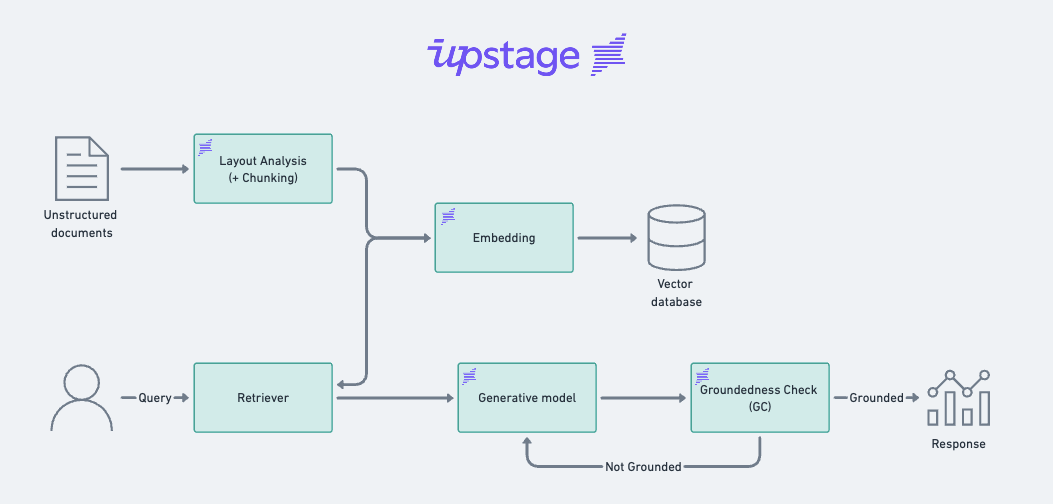

## Environment

In [ ]:
! pip install langchain_core langchain-upstage langchain_chroma langchain langgraph

### LLMs

In [ ]:
import os
os.environ['UPSTAGE_API_KEY'] = <your-api-key>
os.environ['UPSTAGE_DOCUMENT_AI_API_KEY'] = <your-api-key> # TODO: remove this when API keys are consolidated.

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [ ]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

## Retriever

### Prepare a file

Let's download a PDF file. 
If you have your own files to test with, please skip this step.

In [ ]:
from urllib.request import urlretrieve

# Solar paper
# https://arxiv.org/abs/2312.15166 
# SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling
url = ("http://arxiv.org/pdf/2312.15166.pdf")
urlretrieve(url, "Upstage_Solar_DUS.pdf")

### Layout Analysis logic

Prepare a function to use Upstage [Layout Analysis](https://python.langchain.com/docs/integrations/document_loaders/upstage/) for document processing.

In [ ]:
from typing import List
from langchain_core.documents import Document
from langchain_upstage import UpstageLayoutAnalysisLoader

def layout_analysis(filenames: str) -> List[Document]:
    layout_analysis_loader = UpstageLayoutAnalysisLoader(filenames, split="element")
    return layout_analysis_loader.load()

### Indexing

Let's index the file.

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import ChatUpstage, UpstageEmbeddings
from langchain_core.vectorstores import VectorStore

# Add more files if you'd like to.
filenames = [
    "Upstage_Solar_DUS.pdf",
]

db: VectorStore = Chroma(embedding_function=UpstageEmbeddings())
retriever = db.as_retriever()

print("Adding documents to the vectorstore...")

docs = layout_analysis(filenames)
db.add_documents(docs)

print("Finished adding documents to the vectorstore...")

## Graph State
Let's first define the LangGraph state.

In [ ]:
from typing import TypedDict

class RagState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        context: retrieved context
        question: question asked by the user
        answer: generated answer to the question
        groundedness: groundedness of the assistant's response
    """
    context: str
    question: str
    answer: str
    groundedness: str

## RAG

Let's prepare RAG pipeline. It uses Upstage [Solar chat model](https://python.langchain.com/docs/integrations/chat/upstage/).

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate


template = '''Answer the question based only on the given context.
{context}

Question: {question}
'''

prompt = ChatPromptTemplate.from_template(template)
model = ChatUpstage()

rag = prompt | model | StrOutputParser()

def formatDocumentsAsString(docs: List[Document]) -> str:
    return "\n".join([doc.page_content for doc in docs])
    
def retrieve(state: RagState) -> RagState:
    docs = retriever.invoke(state['question'])
    context = formatDocumentsAsString(docs)
    return RagState(context=context)

def modelAnswer(state: RagState) -> RagState:
    response = rag.invoke(state)
    return RagState(answer=response)

Now, let's prepare a logic for using Upstage [Groundedness Check](https://python.langchain.com/docs/integrations/tools/upstage_groundedness_check/).

In [ ]:
from langchain_upstage import GroundednessCheck

gc = GroundednessCheck()
def groundedness_check(state: RagState) -> RagState:
    response = gc.run({"context": state['context'], "answer": state['answer']})
    return RagState(groundedness=response)

def groundedness_condition(state: RagState) -> RagState:
    return state['groundedness']

## Build Graph

Finally, let's put everything together and build the graph! The graph looks like the following.
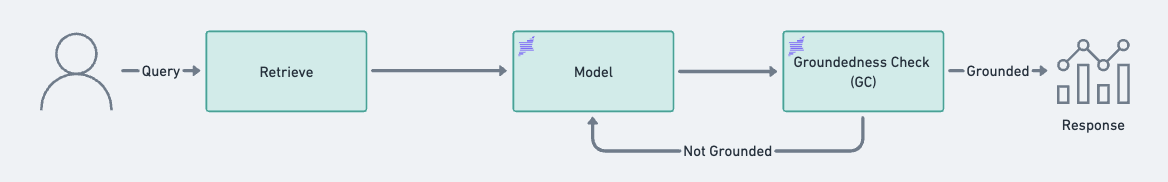

In [ ]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(RagState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("model", modelAnswer)
workflow.add_node("groundedness_check", groundedness_check)

workflow.add_edge("retrieve", "model")
workflow.add_edge("model", "groundedness_check")
workflow.add_conditional_edges("groundedness_check", groundedness_condition, {
    "grounded": END,
    "notGrounded": "model",
    "notSure": "model",
})
workflow.set_entry_point("retrieve")

app = workflow.compile()

## Running the graph

Let's now test the graph.

In [ ]:
inputs = {"question": "What is Solar?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':{value}")
    print("\n---\n")

Node 'retrieve':{'context': 'We present evaluation results for our SOLAR\n10.7B and SOLAR 10.7B-Instruct models along\nBy releasing SOLAR 10.7B under the Apache\n2.0 license, we aim to promote collaboration and in-\nnovation in NLP. This open-source approach allows\nIn conclusion, the ethical framework within\nwhich SOLAR operates is robust and comprehen-\nsive, ensuring that our advancements in this field\nare not only scientifically sound but also ethically\nresponsible.\nAdditionally, we ensure that SOLAR complies\nwith general ethical considerations in all aspects\nof its operation. This includes adherence to pri-\nvacy norms, respect for intellectual property, and\nensuring the absence of bias in our algorithms. Our\ncommitment to these ethical principles is unwaver-\ning, and we believe it significantly contributes to\nthe credibility and societal acceptance of SOLAR.'}

---

Node 'rag':{'answer': 'Solar is an open-source, large language model for natural language processing (NLP

LangSmith Traces - 

* https://smith.langchain.com/public/5ce3f275-b93b-48d1-a718-88139ae2e00b/r